In [ ]:
# 🛒 Retail High-Value Purchase Prediction

**Goal:** Predict whether a purchase is **High Value** (≥ 10,000) or not, using:
- User–Product transaction data
- User demographic data  

We will:
1. Prepare and merge data  
2. Build a Logistic Regression baseline  
3. Build an MLP (Keras) classifier  
4. Compare both models  

**Bonus sections** at the end:
- EXTRA EDA / Analysis
- BONUS: Decision Tree Classifier + Feature Importance


In [1]:
# 🧩 Cell 1: Imports

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)

# For bonus model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# For MLP
from tensorflow.keras import models, layers

# To make output a bit nicer
pd.set_option("display.max_columns", None)


In [2]:
# 🧩 Cell 2: Load Datasets

# If your files are in the same folder as the notebook:
purchase_path = "User_product_purchase_details_p2.csv"
demo_path = "user_demographics.csv"

df_purchase = pd.read_csv(purchase_path)
df_user = pd.read_csv(demo_path)

print("Purchase data shape:", df_purchase.shape)
print("User demographics shape:", df_user.shape)

df_purchase.head()


Purchase data shape: (550068, 9)
User demographics shape: (5891, 4)


,User_ID,Product_ID,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,C,4+,0,8,NaN,NaN,7969


In [3]:
# 🧩 Cell 3: Inspect User Demographics

df_user.head()


,User_ID,Gender,Age,Occupation
0,1000001,F,0-17,10
1,1000002,M,55+,16
2,1000003,M,26-35,15
3,1000004,M,46-50,7
4,1000005,M,26-35,20


In [4]:
# 🧩 Cell 4: Merge on User_ID

df = pd.merge(df_purchase, df_user, on="User_ID", how="left")
print("Merged data shape:", df.shape)
df.head()


Merged data shape: (550068, 12)


,User_ID,Product_ID,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Gender,Age,Occupation
0,1000001,P00069042,A,2,0,3,NaN,NaN,8370,F,0-17,10
1,1000001,P00248942,A,2,0,1,6.0,14.0,15200,F,0-17,10
2,1000001,P00087842,A,2,0,12,NaN,NaN,1422,F,0-17,10
3,1000001,P00085442,A,2,0,12,14.0,NaN,1057,F,0-17,10
4,1000002,P00285442,C,4+,0,8,NaN,NaN,7969,M,55+,16


In [5]:
# 🧩 Cell 5: Basic Data Checks

print("Merged Info:")
df.info()

print("\nMissing Values per Column:")
print(df.isna().sum())


Merged Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   City_Category               550068 non-null  object 
 3   Stay_In_Current_City_Years  550068 non-null  object 
 4   Marital_Status              550068 non-null  int64  
 5   Product_Category_1          550068 non-null  int64  
 6   Product_Category_2          376430 non-null  float64
 7   Product_Category_3          166821 non-null  float64
 8   Purchase                    550068 non-null  int64  
 9   Gender                      550068 non-null  object 
 10  Age                         550068 non-null  object 
 11  Occupation                  550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB



In [6]:
# 🧩 Cell 6: Create Binary Target (High_Value_Purchase)

# 1 → Purchase >= 10000, 0 → otherwise
df["High_Value_Purchase"] = (df["Purchase"] >= 10000).astype(int)

df[["Purchase", "High_Value_Purchase"]].head()


,Purchase,High_Value_Purchase
0,8370,0
1,15200,1
2,1422,0
3,1057,0
4,7969,0


In [7]:
# 🧩 Cell 7: Handle Missing Values

# Simple strategy: fill numerical NAs with 0, categorical NAs with 'Unknown'
# First, let's identify categorical & numerical columns

cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)

# Fill missing values
df[cat_cols] = df[cat_cols].fillna("Unknown")
df[num_cols] = df[num_cols].fillna(0)

df.isna().sum()


Categorical columns: ['Product_ID', 'City_Category', 'Stay_In_Current_City_Years', 'Gender', 'Age']
Numeric columns: ['User_ID', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'Purchase', 'Occupation', 'High_Value_Purchase']


User_ID                       0
Product_ID                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
Gender                        0
Age                           0
Occupation                    0
High_Value_Purchase           0
dtype: int64

In [8]:
# 🧩 Cell 8: Encode Categorical Variables with One-Hot Encoding

# Columns that are clearly categorical (some may already be numeric but represent categories)
categorical_features = ["Gender", "Age", "City_Category", "Stay_In_Current_City_Years"]
# Ensure we don't accidentally include target or IDs
categorical_features = [col for col in categorical_features if col in df.columns]

df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)

print("Shape before encoding:", df.shape)
print("Shape after encoding:", df_encoded.shape)
df_encoded.head()


Shape before encoding: (550068, 13)
Shape after encoding: (550068, 22)


,User_ID,Product_ID,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Occupation,High_Value_Purchase,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_B,City_Category_C,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,1000001,P00069042,0,3,0.0,0.0,8370,10,0,False,False,False,False,False,False,False,False,False,False,True,False,False
1,1000001,P00248942,0,1,6.0,14.0,15200,10,1,False,False,False,False,False,False,False,False,False,False,True,False,False
2,1000001,P00087842,0,12,0.0,0.0,1422,10,0,False,False,False,False,False,False,False,False,False,False,True,False,False
3,1000001,P00085442,0,12,14.0,0.0,1057,10,0,False,False,False,False,False,False,False,False,False,False,True,False,False
4,1000002,P00285442,0,8,0.0,0.0,7969,16,0,True,False,False,False,False,False,True,False,True,False,False,False,True


In [9]:
# 🧩 Cell 9: Drop Unnecessary Columns

# Product_ID and User_ID usually are not useful as features (identifiers)
cols_to_drop = []
if "Product_ID" in df_encoded.columns:
    cols_to_drop.append("Product_ID")
if "User_ID" in df_encoded.columns:
    cols_to_drop.append("User_ID")

df_encoded = df_encoded.drop(columns=cols_to_drop)

df_encoded.head()


,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Occupation,High_Value_Purchase,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,City_Category_B,City_Category_C,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,0,3,0.0,0.0,8370,10,0,False,False,False,False,False,False,False,False,False,False,True,False,False
1,0,1,6.0,14.0,15200,10,1,False,False,False,False,False,False,False,False,False,False,True,False,False
2,0,12,0.0,0.0,1422,10,0,False,False,False,False,False,False,False,False,False,False,True,False,False
3,0,12,14.0,0.0,1057,10,0,False,False,False,False,False,False,False,False,False,False,True,False,False
4,0,8,0.0,0.0,7969,16,0,True,False,False,False,False,False,True,False,True,False,False,False,True


In [10]:
# 🧩 Cell 10: Define Features (X) and Target (y)

X = df_encoded.drop(["High_Value_Purchase", "Purchase"], axis=1)
y = df_encoded["High_Value_Purchase"]

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


Feature matrix shape: (550068, 18)
Target vector shape: (550068,)


In [11]:
# 🧩 Cell 11: Train–Test Split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:\n", y_train.value_counts(normalize=True))
print("y_test distribution:\n", y_test.value_counts(normalize=True))


X_train shape: (440054, 18)
X_test shape: (110014, 18)
y_train distribution:
 High_Value_Purchase
0    0.655426
1    0.344574
Name: proportion, dtype: float64
y_test distribution:
 High_Value_Purchase
0    0.655426
1    0.344574
Name: proportion, dtype: float64


In [12]:
# 🧩 Cell 12: Feature Scaling

scaler = StandardScaler()

# Fit only on training data, transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled.shape, X_test_scaled.shape


((440054, 18), (110014, 18))

In [13]:
# 🧩 Cell 13: Baseline Logistic Regression Model

log = LogisticRegression(max_iter=2000)

log.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = log.predict(X_test_scaled)
y_proba_lr = log.predict_proba(X_test_scaled)[:, 1]

# Evaluation
acc_lr = accuracy_score(y_test, y_pred_lr)
cm_lr = confusion_matrix(y_test, y_pred_lr)
roc_auc_lr = roc_auc_score(y_test, y_proba_lr)

print("🔹 Logistic Regression Accuracy:", acc_lr)
print("🔹 Logistic Regression ROC-AUC:", roc_auc_lr)
print("\nConfusion Matrix (LR):\n", cm_lr)
print("\nClassification Report (LR):\n", classification_report(y_test, y_pred_lr))


🔹 Logistic Regression Accuracy: 0.7661752140636646
🔹 Logistic Regression ROC-AUC: 0.780825658450716

Confusion Matrix (LR):
 [[64702  7404]
 [18320 19588]]

Classification Report (LR):
               precision    recall  f1-score   support

           0       0.78      0.90      0.83     72106
           1       0.73      0.52      0.60     37908

    accuracy                           0.77    110014
   macro avg       0.75      0.71      0.72    110014
weighted avg       0.76      0.77      0.75    110014



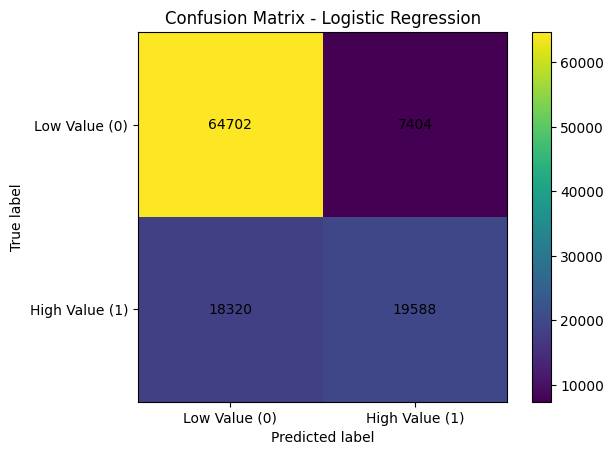

In [14]:
# 🧩 Cell 14: Plot Confusion Matrix for Logistic Regression

fig, ax = plt.subplots()
im = ax.imshow(cm_lr, interpolation='nearest')
ax.set_title("Confusion Matrix - Logistic Regression")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Low Value (0)", "High Value (1)"])
ax.set_yticklabels(["Low Value (0)", "High Value (1)"])

# Annotate values
for i in range(cm_lr.shape[0]):
    for j in range(cm_lr.shape[1]):
        ax.text(j, i, cm_lr[i, j], ha="center", va="center")

plt.colorbar(im, ax=ax)
plt.show()


In [15]:
# 🧩 Cell 15: MLP Classifier (Keras)

input_dim = X_train_scaled.shape[1]
print("Number of input features for MLP:", input_dim)

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_dim,)),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Number of input features for MLP: 18


c:\Users\User\Desktop\mockmock\.venv\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# 🧩 Cell 16: Train the MLP

history = model.fit(
    X_train_scaled,
    y_train,
    epochs=15,
    batch_size=256,
    validation_split=0.2,
    verbose=1
)


Epoch 1/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8118 - loss: 0.4360 - val_accuracy: 0.8219 - val_loss: 0.4079
Epoch 2/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8265 - loss: 0.4003 - val_accuracy: 0.8356 - val_loss: 0.3794
Epoch 3/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8548 - loss: 0.3463 - val_accuracy: 0.8687 - val_loss: 0.3158
Epoch 4/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8748 - loss: 0.3039 - val_accuracy: 0.8786 - val_loss: 0.2944
Epoch 5/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8813 - loss: 0.2918 - val_accuracy: 0.8826 - val_loss: 0.2873
Epoch 6/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8831 - loss: 0.2870 - val_accuracy: 0.8862 - val_loss: 0.2862
Epoch 7/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8838 - loss: 0.2845 - val_accuracy: 0.8833 - val_loss: 0.2863
Epoch 8/15
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8845 - loss: 0.2829 - 

In [17]:
# 🧩 Cell 17: Evaluate MLP on Test Data

loss_mlp, acc_mlp = model.evaluate(X_test_scaled, y_test, verbose=0)
print("🔹 MLP Test Accuracy:", acc_mlp)

# Predictions for more metrics
y_proba_mlp = model.predict(X_test_scaled).ravel()
y_pred_mlp = (y_proba_mlp >= 0.5).astype(int)

cm_mlp = confusion_matrix(y_test, y_pred_mlp)
roc_auc_mlp = roc_auc_score(y_test, y_proba_mlp)

print("🔹 MLP ROC-AUC:", roc_auc_mlp)
print("\nConfusion Matrix (MLP):\n", cm_mlp)
print("\nClassification Report (MLP):\n", classification_report(y_test, y_pred_mlp))


🔹 MLP Test Accuracy: 0.8915956020355225
3438/3438 ━━━━━━━━━━━━━━━━━━━━ 2s 520us/step
🔹 MLP ROC-AUC: 0.9426484602011937

Confusion Matrix (MLP):
 [[62997  9109]
 [ 2817 35091]]

Classification Report (MLP):
               precision    recall  f1-score   support

           0       0.96      0.87      0.91     72106
           1       0.79      0.93      0.85     37908

    accuracy                           0.89    110014
   macro avg       0.88      0.90      0.88    110014
weighted avg       0.90      0.89      0.89    110014



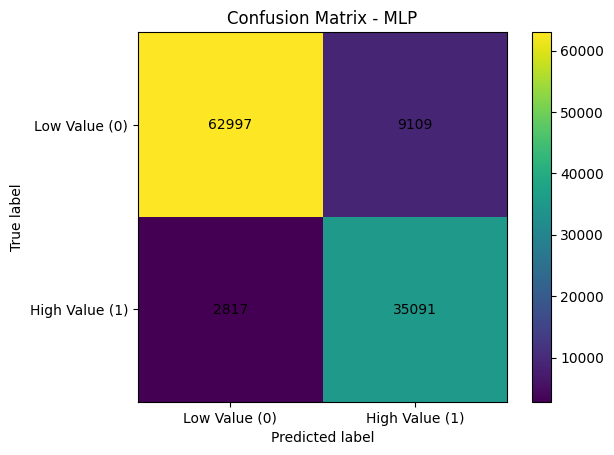

In [18]:
# 🧩 Cell 18: Plot Confusion Matrix for MLP

fig, ax = plt.subplots()
im = ax.imshow(cm_mlp, interpolation='nearest')
ax.set_title("Confusion Matrix - MLP")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Low Value (0)", "High Value (1)"])
ax.set_yticklabels(["Low Value (0)", "High Value (1)"])

for i in range(cm_mlp.shape[0]):
    for j in range(cm_mlp.shape[1]):
        ax.text(j, i, cm_mlp[i, j], ha="center", va="center")

plt.colorbar(im, ax=ax)
plt.show()


In [19]:
# 🧩 Cell 19: Compare Logistic Regression vs MLP

print("🔸 Logistic Regression Accuracy:", acc_lr)
print("🔸 MLP Accuracy:", acc_mlp)

print("🔸 Logistic Regression ROC-AUC:", roc_auc_lr)
print("🔸 MLP ROC-AUC:", roc_auc_mlp)

if acc_mlp > acc_lr:
    print("\n➡ The MLP performs better in terms of accuracy.")
elif acc_mlp < acc_lr:
    print("\n➡ Logistic Regression performs better in terms of accuracy.")
else:
    print("\n➡ Both models have the same accuracy.")


🔸 Logistic Regression Accuracy: 0.7661752140636646
🔸 MLP Accuracy: 0.8915956020355225
🔸 Logistic Regression ROC-AUC: 0.780825658450716
🔸 MLP ROC-AUC: 0.9426484602011937

➡ The MLP performs better in terms of accuracy.


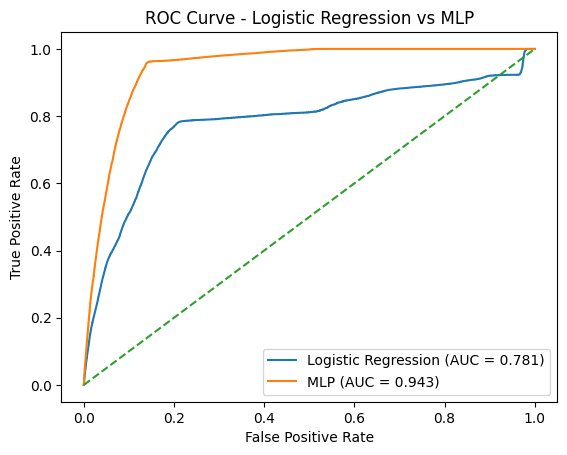

In [20]:
# 🧩 Cell 20: Plot ROC Curves for Both Models

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_proba_mlp)

plt.figure()
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.3f})")
plt.plot(fpr_mlp, tpr_mlp, label=f"MLP (AUC = {roc_auc_mlp:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression vs MLP")
plt.legend()
plt.show()


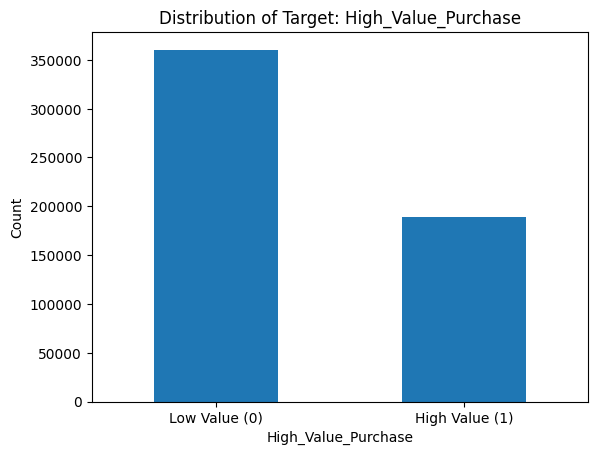

Counts:
 High_Value_Purchase
0    360529
1    189539
Name: count, dtype: int64

Proportions:
 High_Value_Purchase
0    0.655426
1    0.344574
Name: count, dtype: float64


In [21]:
# 🎁 BONUS Cell 21: Target Distribution

target_counts = y.value_counts()
target_counts.plot(kind="bar")
plt.xticks([0, 1], ["Low Value (0)", "High Value (1)"], rotation=0)
plt.title("Distribution of Target: High_Value_Purchase")
plt.ylabel("Count")
plt.show()

print("Counts:\n", target_counts)
print("\nProportions:\n", target_counts / len(y))


In [22]:
# 🎁 BONUS Cell 22: Average Purchase by Age Group and Gender

# For this, it's easier to use original df (not encoded)
avg_purchase_age_gender = df.groupby(["Age", "Gender"])["Purchase"].mean().reset_index()
avg_purchase_age_gender.sort_values(by="Purchase", ascending=False).head(10)


,Age,Gender,Purchase
11,51-55,M,9705.094802
7,36-45,M,9453.193643
3,18-25,M,9440.942971
13,55+,M,9438.195603
5,26-35,M,9410.337578
9,46-50,M,9357.471509
1,0-17,M,9235.173670
10,51-55,F,9042.449666
12,55+,F,9007.036199
6,36-45,F,8959.844056


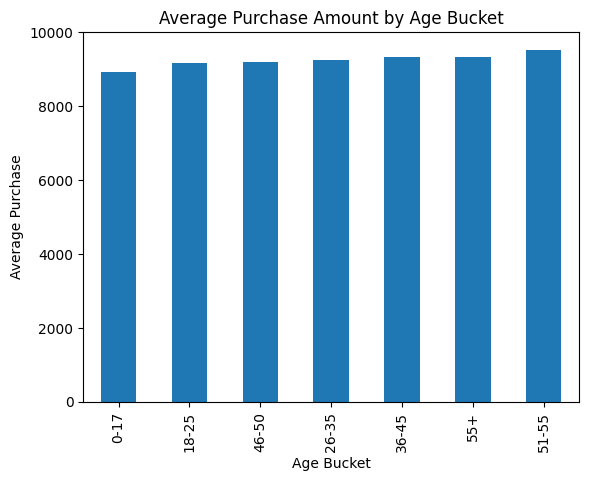

In [23]:
# 🎁 BONUS Cell 23: Plot Average Purchase by Age Bucket

avg_purchase_age = df.groupby("Age")["Purchase"].mean().sort_values()
avg_purchase_age.plot(kind="bar")
plt.title("Average Purchase Amount by Age Bucket")
plt.ylabel("Average Purchase")
plt.xlabel("Age Bucket")
plt.show()


In [24]:
# 🎁 BONUS Cell 24: Decision Tree Classifier

dtree = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=50,
    random_state=42
)

dtree.fit(X_train, y_train)

y_pred_dt = dtree.predict(X_test)
y_proba_dt = dtree.predict_proba(X_test)[:, 1]

acc_dt = accuracy_score(y_test, y_pred_dt)
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
cm_dt = confusion_matrix(y_test, y_pred_dt)

print("🔹 Decision Tree Accuracy:", acc_dt)
print("🔹 Decision Tree ROC-AUC:", roc_auc_dt)
print("\nConfusion Matrix (Decision Tree):\n", cm_dt)
print("\nClassification Report (Decision Tree):\n", classification_report(y_test, y_pred_dt))


🔹 Decision Tree Accuracy: 0.8897867544130748
🔹 Decision Tree ROC-AUC: 0.9394611711716752

Confusion Matrix (Decision Tree):
 [[62238  9868]
 [ 2257 35651]]

Classification Report (Decision Tree):
               precision    recall  f1-score   support

           0       0.97      0.86      0.91     72106
           1       0.78      0.94      0.85     37908

    accuracy                           0.89    110014
   macro avg       0.87      0.90      0.88    110014
weighted avg       0.90      0.89      0.89    110014



In [25]:
# 🎁 BONUS Cell 25: Decision Tree Feature Importance

feature_importances = pd.Series(dtree.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

print("Top 15 most important features:")
feature_importances.head(15)


Top 15 most important features:


Product_Category_1              0.994327
Product_Category_2              0.002605
City_Category_C                 0.001514
Product_Category_3              0.001081
City_Category_B                 0.000287
Occupation                      0.000132
Age_26-35                       0.000033
Gender_M                        0.000021
Marital_Status                  0.000000
Age_18-25                       0.000000
Age_46-50                       0.000000
Age_36-45                       0.000000
Age_55+                         0.000000
Age_51-55                       0.000000
Stay_In_Current_City_Years_1    0.000000
dtype: float64

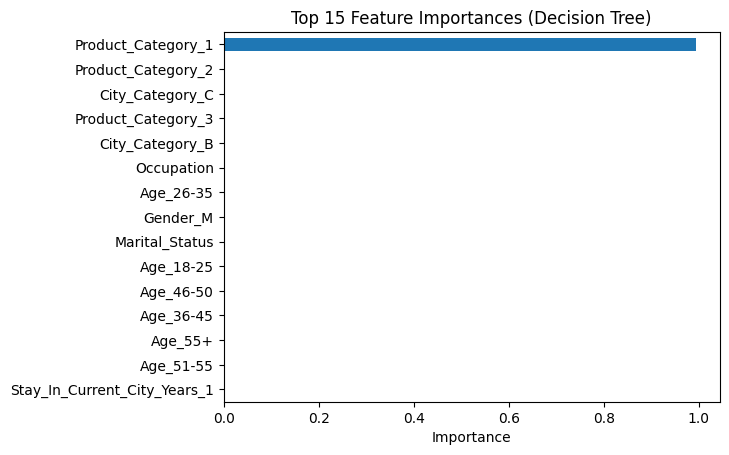

In [26]:
# 🎁 BONUS Cell 26: Plot Top Feature Importances

top_n = 15
top_features = feature_importances.head(top_n)

top_features.plot(kind="barh")
plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.show()


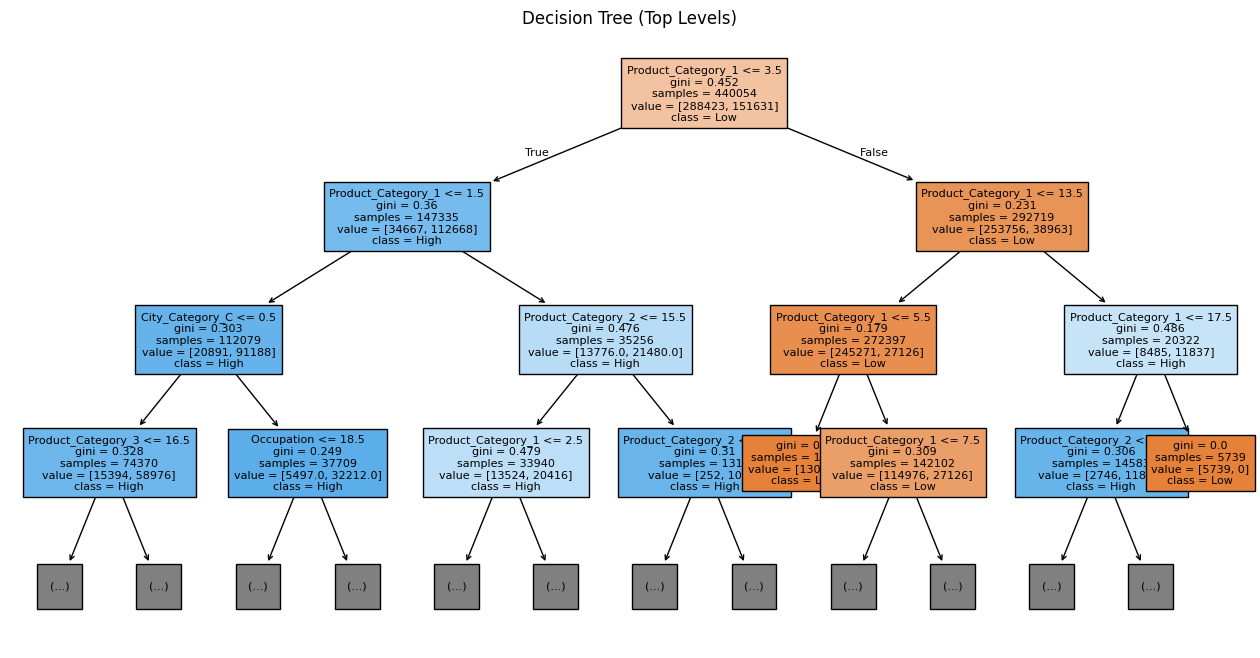

In [27]:
# 🎁 BONUS Cell 27: Visualize Part of the Decision Tree (optional)

plt.figure(figsize=(16, 8))
plot_tree(
    dtree,
    feature_names=X.columns,
    class_names=["Low", "High"],
    filled=True,
    max_depth=3,  # show only the top few levels
    fontsize=8
)
plt.title("Decision Tree (Top Levels)")
plt.show()
